# Quantile loss for regression

https://hippocampus-garden.com/lgbm_custom/

## Setup libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
import lightgbm as lgb

In [7]:
import matplotlib.pyplot as plt

In [8]:
warnings.simplefilter("ignore")

## Utility functions

In [9]:
def print_mse_performance(model, X_test, y_test, name):
    'display mean-squared-error for fitted model'

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    model_name = model.__class__.__name__
    print('{}, {}, mse = {:.2f}'.format(model_name, name, mse))

In [10]:
def plot_actual_predict(actual, predict, ax, title):
    'plot actual label vs predicted label'
    model_predict = pd.DataFrame(
        {'actual': actual, 'predict': predict, 'residual': predict - actual}
    )
    ax = sns.scatterplot(x='actual', y='predict', data=model_predict, ax=ax)
    (xmin, xmax), (ymin, ymax) = [ax.get_xlim(), ax.get_ylim()]
    min_axis, max_axis = min(xmin, ymin), max(xmax, ymax)
    ax.set_xlim(min_axis, max_axis)
    ax.set_ylim(min_axis, max_axis)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    ax.set_title(title)

In [11]:
def plot_actual_residual(actual, predict, ax, title):
    'plot actual label vs residual (predict - actual)'
    model_predict = pd.DataFrame(
        {'actual': actual, 'predict': predict, 'residual': predict - actual}
    )
    ax = sns.scatterplot(x='actual', y='residual', data=model_predict, ax=ax)
    ax.axhline(y=0, color='red', linestyle='dotted')
    ax.set_title(title)

In [12]:
def train_early_stopping_lgb(lgbm_params, lgb_train, lgb_eval):
    'train lightgbm model with early stopping'
    model = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        verbose_eval=-1,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )
    return model

In [13]:
def l2_loss(y, data):
    t = data.get_label()
    grad = y - t
    hess = np.ones_like(y)
    return grad, hess

In [14]:
def l2_eval(y, data):
    t = data.get_label()
    loss = (y - t) ** 2
    return 'l2', loss.mean(), False

In [15]:
def train_custom_loss():
    return lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        verbose_eval=-1,
        fobj=l2_loss, feval=l2_eval,
        callbacks=[lgb.early_stopping(10, verbose=False)],
    )

## Get data

In [16]:
raw_data = sns.load_dataset('tips')

In [17]:
raw_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [18]:
raw_data.dtypes.value_counts()

float64     2
category    1
category    1
category    1
category    1
int64       1
dtype: int64

## Setup features, label

In [19]:
y = raw_data.total_bill
X = raw_data.drop(columns=['total_bill'])

Split data into train and test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0
)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [21]:
y_ind = y_test < y_test.median()
y_lower = y_test[y_ind]
X_lower = X_test[y_ind]
y_higher = y_test[~y_ind]
X_higher = X_test[~y_ind]

In [22]:
lgbm_params = {'objective': 'mse', 'random_seed': 0, 'verbose': -1}
gbm_mse = train_early_stopping_lgb(lgbm_params, lgb_train, lgb_eval)

In [23]:
lgbm_params = {
    'objective': 'quantile',
    'alpha': 0.10,
    'random_seed': 0,
    'verbose': -1,
}
gbm_p10 = train_early_stopping_lgb(lgbm_params, lgb_train, lgb_eval)

In [24]:
lgbm_params = {
    'objective': 'quantile',
    'alpha': 0.90,
    'random_seed': 0,
    'verbose': -1,
}
gbm_p90 = train_early_stopping_lgb(lgbm_params, lgb_train, lgb_eval)

In [25]:
print_mse_performance(gbm_mse, X_test, y_test, 'mse')
print_mse_performance(gbm_p10, X_test, y_test, 'percentile 10')
print_mse_performance(gbm_p90, X_test, y_test, 'percentile 90')

Booster, mse, mse = 31.89
Booster, percentile 10, mse = 71.30
Booster, percentile 90, mse = 162.67


In [26]:
print_mse_performance(gbm_mse, X_lower, y_lower, 'lower: mse')
print_mse_performance(gbm_p10, X_lower, y_lower, 'lower: percentile 10')
print_mse_performance(gbm_p90, X_lower, y_lower, 'lower: percentile 90')

Booster, lower: mse, mse = 24.86
Booster, lower: percentile 10, mse = 9.07
Booster, lower: percentile 90, mse = 176.91


In [27]:
print_mse_performance(gbm_mse, X_higher, y_higher, 'higher: mse')
print_mse_performance(gbm_p10, X_higher, y_higher, 'higher: percentile 10')
print_mse_performance(gbm_p90, X_higher, y_higher, 'higher: percentile 90')

Booster, higher: mse, mse = 38.75
Booster, higher: percentile 10, mse = 132.01
Booster, higher: percentile 90, mse = 148.77


Text(0.5, 0, 'p90')

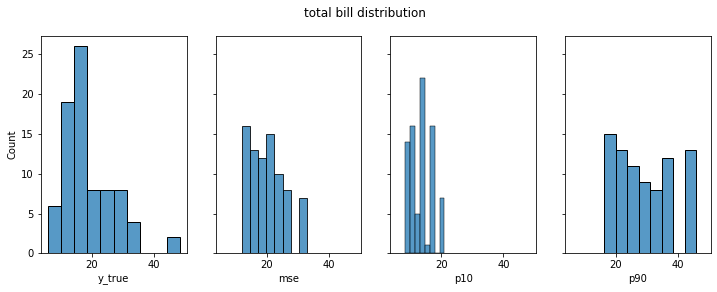

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4, figsize=(12, 4), sharex=True, sharey=True
)
fig.suptitle('total bill distribution')
sns.histplot(y_test, ax=ax1).set_xlabel('y_true')
sns.histplot(gbm_mse.predict(X_test), ax=ax2).set_xlabel('mse')
sns.histplot(gbm_p10.predict(X_test), ax=ax3).set_xlabel('p10')
sns.histplot(gbm_p90.predict(X_test), ax=ax4).set_xlabel('p90')

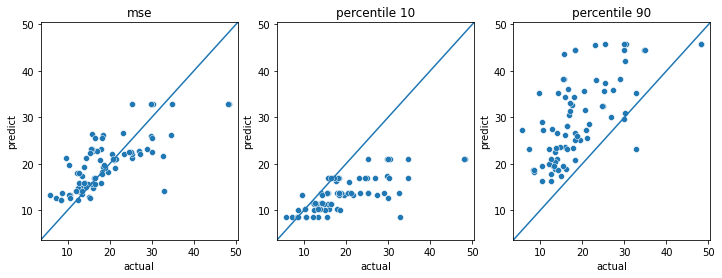

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_actual_predict(y_test, gbm_mse.predict(X_test), ax1, 'mse')
plot_actual_predict(y_test, gbm_p10.predict(X_test), ax2, 'percentile 10')
plot_actual_predict(y_test, gbm_p90.predict(X_test), ax3, 'percentile 90')

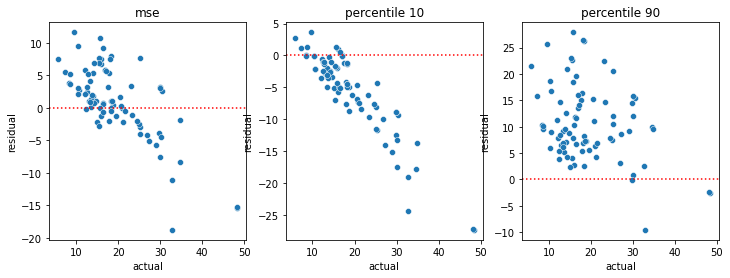

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_actual_residual(y_test, gbm_mse.predict(X_test), ax1, 'mse')
plot_actual_residual(y_test, gbm_p10.predict(X_test), ax2, 'percentile 10')
plot_actual_residual(y_test, gbm_p90.predict(X_test), ax3, 'percentile 90')